In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt#
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import sys
sys.path.append("/Users/marcsauer/PycharmProjects/Swim/src/")
from preprocessing import Preprocessing
import glob

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

Roadmap:
1. Data cleaning and formatting
2. Exploratory data analysis
3. Feature engineering and selection
4. Establish a baseline and compare several machine learning models on a performance metric
5. Perform hyperparameter tuning on the best model to optimize it for the problem
6. Evaluate the best model on the testing set
7. Interpret the model results to the extent possible
8. Draw conclusions and write a well-documented report

# Problem definition

Die Leistung beim Schwimmen ist im Vergleich zu anderen Fortbewegungsformen (z.B. Laufen) stark technikabhängig. Dies lässt sich anhand der verschiedenen Medien (Wasser vs. Luft) erklären, in denen sich ein Körper fortbewegt. Da hierbei Wasser eine höhere Dichte als Luft besitzt, hat die Schwimmtechnik einen höheren Stellenwert im Hinblick auf die Leistung als die Lauftechnik dies beim Laufen hat. Die Schwimmleistung ist im Allgemeinen vom Vortrieb und aktivem Widerstand abhängig. Aus den dargelegten Gründen sind Schwimmer stets um eine saubere (und somit schnelleren) Schwimmtechnik bemüht. Die Schwimmtechnik wird normalerweise von ausgebildeten Schwimmtrainern evaluiert. Dies erfolgt auf Grundlage der Erfahrung des Trainers. In der Regel ist dies mit erheblichen Kosten und Aufwand verbunden. Ziel dieses Projektes ist es, ein Produkt zu entwerfen, welches die Schwimmtechnik automatisiert evaluieren kann. Somit können Technikschwächen aufgedeckt werden und in einem weiteren Schritt korrigierende Übungsanweisungen gegeben werden.

Supervised: Daten sind gelabelt.

Klassifizierung: Schwimmtechnik ist eine diskrete Variable.

Somit handelt es sich um ein Klassifizierungsproblem, welches mit einem Modell der Kategorie 'Supervised' gelöst werden kann.

# Data cleaning

In [242]:
testrun = 'Run_0_2'
pre = Preprocessing(testrun)

In [243]:
# Load data
raw_accel = pre.load_data('accel-175130000657-20190405T093805Z.csv', name='raw_accel', header=None)
raw_gyro = pre.load_data('gyro-175130000657-20190405T093806Z.csv', name='raw_gyro', header=None)
raw_magn = pre.load_data('magn-175130000657-20190405T093805Z.csv', name='raw_magn', header=None)

In [244]:
# Create data frame with all sensor information
column_names = ['Accel_X', 'Accel_Y', 'Accel_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'Magn_X', 'Magn_Y', 'Magn_Z']
raw_data = pd.concat([raw_accel, raw_gyro, raw_magn], axis=1, sort=False)
raw_data.columns = column_names
raw_data.head(5)

,Accel_X,Accel_Y,Accel_Z,Gyro_X,Gyro_Y,Gyro_Z,Magn_X,Magn_Y,Magn_Z
0,-3.254355,2.110545,-9.016478,-2.38,0.49,2.31,-67.950005,-58.200001,165.450012
1,-3.062922,2.024400,-8.978191,1.12,2.10,2.94,-69.150002,-58.650002,163.950012
2,-3.306999,1.876040,-8.959048,0.00,0.14,2.80,-67.950005,-56.850002,165.150009
3,-3.007885,1.713322,-9.375414,-5.25,0.21,-2.31,-67.950005,-60.600002,165.600006
4,-3.326142,1.718108,-9.404129,-4.41,4.55,-6.09,-66.900002,-59.400002,164.100006


In [5]:
raw_data.shape

(4033, 9)

In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4033 entries, 0 to 4032
Data columns (total 9 columns):
Accel_X    4033 non-null float64
Accel_Y    4033 non-null float64
Accel_Z    4033 non-null float64
Gyro_X     4033 non-null float64
Gyro_Y     4033 non-null float64
Gyro_Z     4033 non-null float64
Magn_X     4033 non-null float64
Magn_Y     4033 non-null float64
Magn_Z     4033 non-null float64
dtypes: float64(9)
memory usage: 283.6 KB


In [7]:
# Function to calculate missing values by column
def missing_values_table(raw_data):
        # Total missing values
        mis_val = raw_data.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * raw_data.isnull().sum() / len(raw_data)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(raw_data.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [8]:
missing_values_table(raw_data)

Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


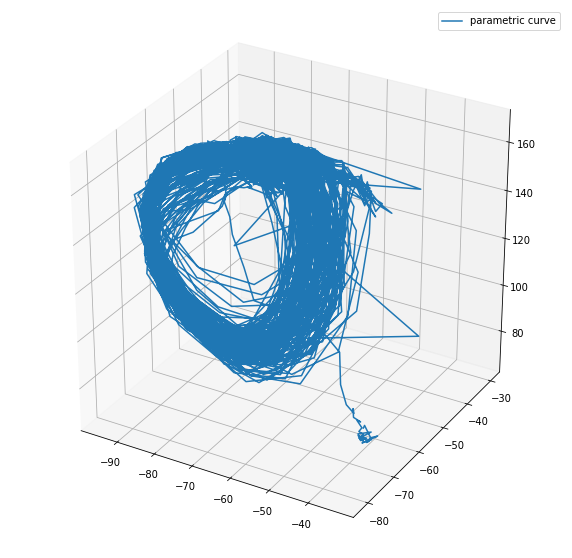

In [9]:
# Plot data (13 Hz)
fig = plt.figure(10, figsize= (10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(raw_data['Magn_X'], raw_data['Magn_Y'], raw_data['Magn_Z'], label='parametric curve')
ax.legend()
plt.show()

# Preprocessing

Um ein Modell trainieren zu können, müssen die Schwimmzüge als einzelne Input-Daten vorhanden sein. Zunächst muss eine geeignete Stelle des Schwimmzuges definiert werden, bei der ein sauberer Cut sinnvoll ist. Hierzu lasse ich mir die zeitliche Verläufe der einzelnen Sensordaten plotten:

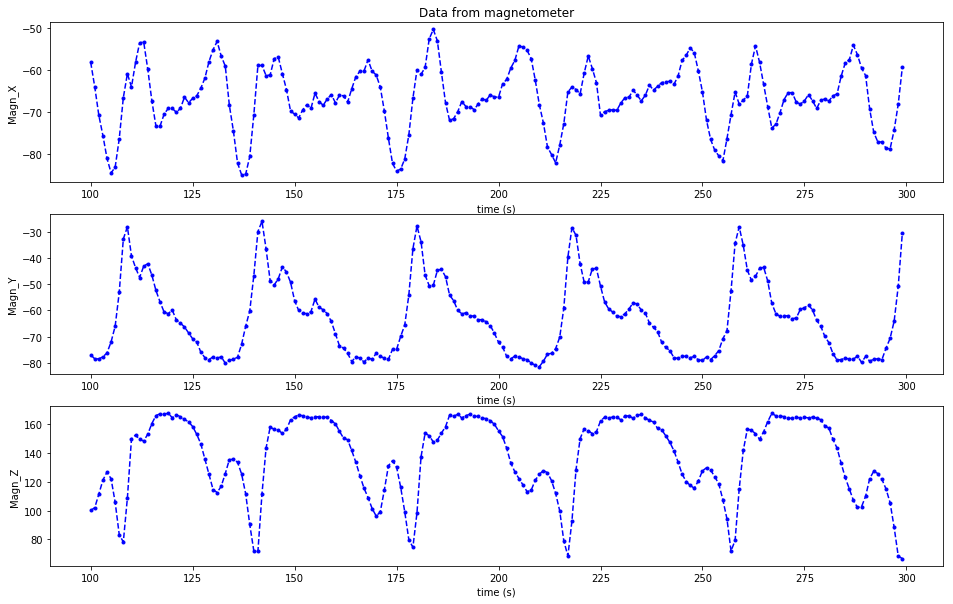

In [103]:
# Create plots of magnetometer data
fig, (ax1, ax2, ax3) = plt.subplots(3, sharey=False, figsize=(16, 10))

ax1.plot(raw_data[100:300].index, raw_data[100:300]['Magn_X'], 'b.--')
ax1.set(title='Data from magnetometer', xlabel='time (s)', ylabel='Magn_X')

ax2.plot(raw_data[100:300].index, raw_data[100:300]['Magn_Y'],'b.--')
ax2.set(xlabel='time (s)', ylabel='Magn_Y')

ax3.plot(raw_data[100:300].index, raw_data[100:300]['Magn_Z'],'b.--')
ax3.set(xlabel='time (s)', ylabel='Magn_Z')

plt.show()

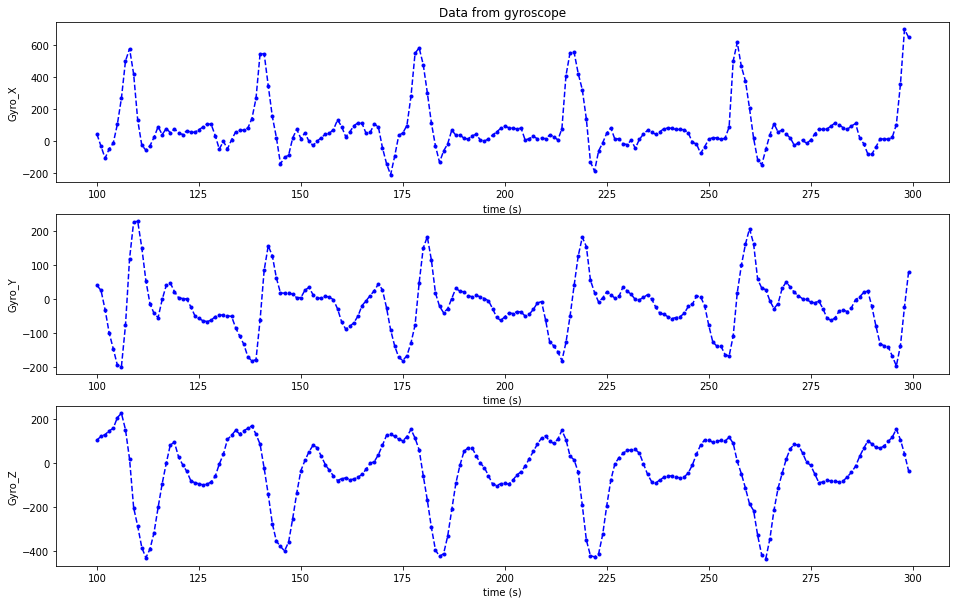

In [104]:
# Create plots of gyroscope data
fig, (ax1, ax2, ax3) = plt.subplots(3, sharey=False, figsize=(16, 10))

ax1.plot(raw_data[100:300].index, raw_data[100:300]['Gyro_X'], 'b.--')
ax1.set(title='Data from gyroscope', xlabel='time (s)', ylabel='Gyro_X')

ax2.plot(raw_data[100:300].index, raw_data[100:300]['Gyro_Y'],'b.--')
ax2.set(xlabel='time (s)', ylabel='Gyro_Y')

ax3.plot(raw_data[100:300].index, raw_data[100:300]['Gyro_Z'],'b.--')
ax3.set(xlabel='time (s)', ylabel='Gyro_Z')

plt.show()

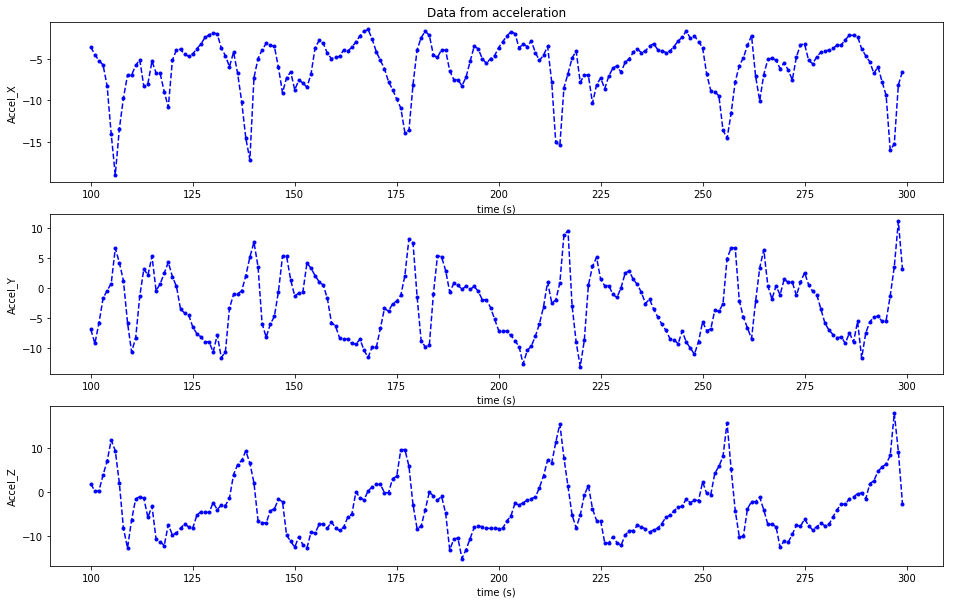

In [105]:
# Create plots of acceleration data
fig, (ax1, ax2, ax3) = plt.subplots(3, sharey=False, figsize=(16, 10))

ax1.plot(raw_data[100:300].index, raw_data[100:300]['Accel_X'], 'b.--')
ax1.set(title='Data from acceleration', xlabel='time (s)', ylabel='Accel_X')

ax2.plot(raw_data[100:300].index, raw_data[100:300]['Accel_Y'],'b.--')
ax2.set(xlabel='time (s)', ylabel='Accel_Y')

ax3.plot(raw_data[100:300].index, raw_data[100:300]['Accel_Z'],'b.--')
ax3.set(xlabel='time (s)', ylabel='Accel_Z')

plt.show()

Der Parameter (Achse), von welchem der stroke_cut abhängig gemacht wird, muss 2 Bedingungen erfüllen:
1. Der Parameter muss sich sowohl im Wasser als auch an Land gleich verhalten (da die Daten für das Modell an Land generiert wurden)
2. Der Parameter muss sich bei beiden Bedingungen (high elbow catch vs. deep catch) im zeitlichen Verlauf gleich/ähnlich verhalten

Am besten geeignet hierfür ist: Magn_Y

In [251]:
# Create data frame for every single stroke and save as csv
def single_stroke(raw_data, testrun):
    # Define stroke cut
    Magn_Y_max = raw_data['Magn_Y'].max()
    Magn_Y_min = raw_data['Magn_Y'].min()
    min_max_range = Magn_Y_max - Magn_Y_min
    stroke_cut = Magn_Y_max - (min_max_range * 0.30)
    
    # Cut stroke
    single_stroke_end = []
    for i in range(0,len(raw_data['Magn_Y'])):
        if (raw_data['Magn_Y'][i] > stroke_cut) == True and (raw_data['Magn_Y'][i-1] < stroke_cut) == True:
            single_stroke_end.append(i)
    print(single_stroke_end)
    
    # Length of single stroke plus variance
    single_stroke_len = []
    for end in range(1, len(single_stroke_end)):
        stroke_len = single_stroke_end[end]-single_stroke_end[end-1]
        single_stroke_len.append(stroke_len)
    print(single_stroke_len)
    print(np.var(single_stroke_len))
    
    # Create list of data frames
    single_stroke_end_mod = [-1] + single_stroke_end
    list_of_dfs = [raw_data.iloc[single_stroke_end_mod[n]+1:single_stroke_end_mod[n+1]+1] for n in range(len(single_stroke_end_mod)-1)]
    
    # Save single strokes to csv
    k = 1
    for i in range(0, len(list_of_dfs)):
        pd.DataFrame(list_of_dfs[i]).to_csv('/Users/marcsauer/PycharmProjects/Swim/data/{}/stroke_{}.csv'.format(testrun, k), index=False)
        k += 1

In [252]:
single_stroke(raw_data, testrun)

[31, 58, 86, 112, 138, 165, 193, 219, 248, 274, 300, 327, 353, 382, 410, 440, 467, 494, 522, 549, 576, 603, 630, 656, 683, 710, 737, 763, 790, 817, 845, 873, 900, 926, 953, 980, 1009, 1038, 1068, 1096, 1126, 1155, 1182, 1210, 1239, 1268, 1296, 1324, 1352, 1380, 1408, 1437, 1466, 1496, 1525, 1555, 1586, 1616, 1646, 1675, 1705, 1736, 1764, 1794, 1823, 1853, 1882, 1911, 1939, 1968, 1997, 2026, 2054, 2083, 2111, 2140, 2168, 2195, 2223, 2251, 2280, 2311, 2339, 2368, 2397, 2426, 2455, 2483, 2512, 2542, 2569, 2599, 2627, 2657, 2686, 2715, 2742, 2770, 2798, 2828, 2857, 2887, 2914, 2943, 2973, 3001, 3030, 3059, 3088, 3117, 3144, 3175, 3203, 3232, 3260, 3290, 3317, 3346, 3376, 3406, 3434, 3463, 3493, 3522, 3551, 3579, 3608, 3637, 3665, 3693, 3722, 3753, 3784, 3813, 3842, 3871, 3899, 3929, 3959, 3989, 4018]
[27, 28, 26, 26, 27, 28, 26, 29, 26, 26, 27, 26, 29, 28, 30, 27, 27, 28, 27, 27, 27, 27, 26, 27, 27, 27, 26, 27, 27, 28, 28, 27, 26, 27, 27, 29, 29, 30, 28, 30, 29, 27, 28, 29, 29, 28, 28, 28,

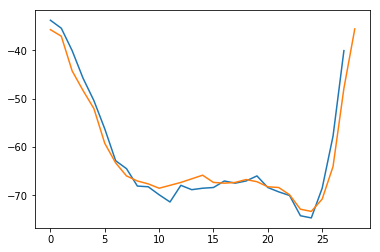

In [267]:
# Load single stroke
#single_stroke_0_2_1 = pd.read_csv('/Users/marcsauer/PycharmProjects/Swim/data/Run_0_2/stroke_1.csv')
single_stroke_0_2_126= pd.read_csv('/Users/marcsauer/PycharmProjects/Swim/data/Run_0_2/stroke_126.csv')
single_stroke_0_2_128 = pd.read_csv('/Users/marcsauer/PycharmProjects/Swim/data/Run_0_2/stroke_128.csv')

# Plot stroke
#plt.plot(single_stroke_0_2_1['Magn_Y'])
plt.plot(single_stroke_0_2_126['Magn_Y'])
plt.plot(single_stroke_0_2_128['Magn_Y'])

plt.show()

## Feature engineering

In [255]:
condition_0 = '/Users/marcsauer/PycharmProjects/Swim/data/Run_0_*/stroke_*.csv'
condition_1 = '/Users/marcsauer/PycharmProjects/Swim/data/Run_1_*/stroke_*.csv'

In [366]:
def feature_dataframe(condition):
    '''Creating features from single stroke and merge into new data frame'''
    Magn_Y_mean = []
    Magn_Y_min = []
    Gyro_Y_mean = []
    Gyro_Y_min = []
    
    # Load data
    for file in glob.glob(condition):
        single_stroke = pd.read_csv(file)
        
    # Feature engineering
        # Magn_Y_mean
        single_stroke_magn_y_mean = single_stroke["Magn_Y"].mean()
        Magn_Y_mean.append(single_stroke_magn_y_mean)
        
        # Magn_Y_min
        single_stroke_magn_y_min = single_stroke["Magn_Y"].min()
        Magn_Y_min.append(single_stroke_magn_y_min)
        
        # Gyro_Y_mean
        single_stroke_gyro_y_mean = single_stroke["Gyro_Y"].mean()
        Gyro_Y_mean.append(single_stroke_gyro_y_mean)
        
         # Gyro_Y_min
        single_stroke_gyro_y_min = single_stroke["Gyro_Y"].min()
        Gyro_Y_min.append(single_stroke_gyro_y_min)
        
    # Create new data frame
    feature_dataframe = pd.DataFrame({'Magn_Y_mean':Magn_Y_mean, 'Magn_Y_min':Magn_Y_min, 'Gyro_Y_mean':Gyro_Y_mean, 'Gyro_Y_min':Gyro_Y_min})    

    # Add condition to data frame
    if condition == condition_0:
        feature_dataframe['condition'] = 0
    elif condition == condition_1:
        feature_dataframe['condition'] = 1
    else:
        print('No condition as input') # nicht wirksam
    return feature_dataframe

In [367]:
# Create clean data
feature_df_0 = feature_dataframe(condition_0)
feature_df_1 = feature_dataframe(condition_1)

frames = [feature_df_0, feature_df_1]
feature_df_clean = pd.concat(frames)
pd.DataFrame(feature_df_clean).to_csv('/Users/marcsauer/PycharmProjects/Swim/data/clean_data.csv', index=False)

In [368]:
clean_data = pd.read_csv('/Users/marcsauer/PycharmProjects/Swim/data/clean_data.csv')

In [369]:
clean_data.head()

,Magn_Y_mean,Magn_Y_min,Gyro_Y_mean,Gyro_Y_min,condition
0,-61.622225,-75.150002,-1.169258,-252.630005,0
1,-61.991382,-78.000000,0.357241,-251.720001,0
2,-61.841383,-74.550003,-18.419655,-245.559998,0
3,-58.877589,-73.650002,-21.567242,-270.130005,0
4,-59.046431,-73.500000,2.344999,-182.630005,0


In [370]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577 entries, 0 to 576
Data columns (total 5 columns):
Magn_Y_mean    577 non-null float64
Magn_Y_min     577 non-null float64
Gyro_Y_mean    577 non-null float64
Gyro_Y_min     577 non-null float64
condition      577 non-null int64
dtypes: float64(4), int64(1)
memory usage: 22.6 KB


In [371]:
clean_data.groupby(['condition']).describe()

Gyro_Y_mean                                                        \
                count       mean       std        min        25%        50%   
condition                                                                     
0               278.0  -6.118234  9.938789 -38.362334 -11.858850  -5.451351   
1               299.0 -19.403301  8.240501 -38.680000 -25.051342 -21.089744   

                                Gyro_Y_min                ...     Magn_Y_mean  \
                 75%        max      count        mean    ...             75%   
condition                                                 ...                   
0           0.720417  21.721725      278.0 -211.659857    ...      -57.597695   
1         -13.775597   4.069722      299.0 -166.863847    ...      -61.526637   

                     Magn_Y_min                                              \
                 max      count       mean       std         min        25%   
condition                                                                     
0         -53.418752      278.0 -73.880938  2.884112  -81.750000 -75.750000   
1         -57.900002      299.0 -79.721241  2.084420 -114.000008 -79.950005   

                                            
                 50%        75%        max  
condition                                   
0         -73.875004 -71.887505 -66.150002  
1         -79.500000 -79.200005 -78.000000  

[2 rows x 32 columns]

# Train model

In [372]:
# Logistische Regression mit 1 Feature
X = clean_data.drop(['Magn_Y_mean', 'Magn_Y_min', 'Gyro_Y_min', 'condition'], axis=1)
y = clean_data['condition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

logreg = LogisticRegression(solver='liblinear', multi_class='ovr')
model_logreg = logreg.fit(X_train, y_train)

score_logreg = model_logreg.score(X_val, y_val)
print('Score Logistic Regression: {}%'.format(score_logreg*100))

Score Logistic Regression: 74.13793103448276%


---

In [373]:
# Logistische Regression mit 4 Features
X = clean_data.drop(['condition'], axis=1)
y = clean_data['condition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

logreg = LogisticRegression(solver='liblinear', multi_class='ovr')
model_logreg = logreg.fit(X_train, y_train)

score_logreg = model_logreg.score(X_val, y_val)
print('Score Logistic Regression: {}%'.format(score_logreg*100))

Score Logistic Regression: 90.51724137931035%
